# LUCAS  (LUng CAncer Simple set)

Data generated artificially by causal Bayesian networks with binary variables

Data was generated with the following porbabilities:

* P(Anxiety=T)=0.64277

* P(Peer Pressure=T)=0.32997

* P(Smoking=T|Peer Pressure=F, Anxiety=F)=0.43118

* P(Smoking=T|Peer Pressure=T, Anxiety=F)=0.74591

* P(Smoking=T|Peer Pressure=F, Anxiety=T)=0.8686

* P(Smoking=T|Peer Pressure=T, Anxiety=T)=0.91576

* P(Yellow Fingers=T|Smoking=F)=0.23119

* P(Yellow Fingers=T|Smoking=T)=0.95372

* P(Genetics=T)=0.15953

* P(Lung cancer=T|Genetics=F, Smoking=F)=0.23146

* P(Lung cancer=T|Genetics=T, Smoking=F)=0.86996

* P(Lung cancer=T|Genetics=F, Smoking=T)=0.83934

* P(Lung cancer=T|Genetics=T, Smoking=T)=0.99351

* P(Attention Disorder=T|Genetics=F)=0.28956

* P(Attention Disorder=T|Genetics=T)=0.68706

* P(Born an Even Day=T)=0.5

* P(Allergy=T)=0.32841

* P(Coughing=T|Allergy=F, Lung cancer=F)=0.1347

* P(Coughing=T|Allergy=T, Lung cancer=F)=0.64592

* P(Coughing=T|Allergy=F, Lung cancer=T)=0.7664

* P(Coughing=T|Allergy=T, Lung cancer=T)=0.99947

* P(Fatigue=T|Lung cancer=F, Coughing=F)=0.35212

* P(Fatigue=T|Lung cancer=T, Coughing=F)=0.56514

* P(Fatigue=T|Lung cancer=F, Coughing=T)=0.80016

* P(Fatigue=T|Lung cancer=T, Coughing=T)=0.89589

* P(Car Accident=T|Attention Disorder=F, Fatigue=F)=0.2274

* P(Car Accident=T|Attention Disorder=T, Fatigue=F)=0.779

* P(Car Accident=T|Attention Disorder=F, Fatigue=T)=0.78861

* P(Car Accident=T|Attention Disorder=T, Fatigue=T)=0.97169

In [1]:
import dowhy
import dowhy.datasets, dowhy.plotter
from dowhy import CausalModel
from dowhy import causal_estimators
import seaborn as sns
import graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import Image, display
from utility_functions import *

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

from numpy import mean
from numpy import std
from numpy.random import randn
from numpy.random import seed
from matplotlib import pyplot

### Load the data

In [2]:
df = pd.read_csv('lucas0_train.csv')
df.head()

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1


In [30]:
df.shape

In [3]:
feature_names = list(df.columns)
feature_names

['Smoking',
 'Yellow_Fingers',
 'Anxiety',
 'Peer_Pressure',
 'Genetics',
 'Attention_Disorder',
 'Born_an_Even_Day',
 'Car_Accident',
 'Fatigue',
 'Allergy',
 'Coughing',
 'Lung_cancer']

In [4]:
corr = df.corr()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
corr.style.background_gradient(cmap, axis=1)\
.set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
.set_caption("Hover to magify")\
.set_precision(2)\
.set_table_styles(magnify())

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
Smoking,1.00,0.77,0.40,0.15,0.01,0.00,-0.02,0.05,0.16,0.04,0.26,0.49
Yellow_Fingers,0.77,1.00,0.31,0.11,-0.00,0.01,-0.01,0.05,0.12,0.05,0.21,0.38
Anxiety,0.40,0.31,1.00,0.00,0.01,-0.01,-0.04,0.03,0.05,0.02,0.14,0.19
Peer_Pressure,0.15,0.11,0.00,1.00,0.02,0.02,-0.01,0.02,0.03,-0.01,0.05,0.06
Genetics,0.01,-0.00,0.01,0.02,1.00,0.27,-0.02,0.15,0.10,-0.01,0.14,0.23
Attention_Disorder,0.00,0.01,-0.01,0.02,0.27,1.00,-0.02,0.30,0.03,0.02,0.05,0.07
Born_an_Even_Day,-0.02,-0.01,-0.04,-0.01,-0.02,-0.02,1.00,-0.03,-0.03,-0.03,-0.03,-0.01
Car_Accident,0.05,0.05,0.03,0.02,0.15,0.30,-0.03,1.00,0.46,0.04,0.21,0.17
Fatigue,0.16,0.12,0.05,0.03,0.10,0.03,-0.03,0.46,1.00,0.09,0.46,0.37
Allergy,0.04,0.05,0.02,-0.01,-0.01,0.02,-0.03,0.04,0.09,1.00,0.31,-0.03


## TUTORIAL 2

## STEP 1: Model the problem as a causal graph

### Create Causal Graph

In [5]:
# Get all features names from df
feature_names = list(df.columns)
target_node = 'Lung_cancer'

In [6]:
# Create edges
edges_list = [('Anxiety','Smoking'), ('Peer_Pressure','Smoking'), ('Smoking','Yellow_Fingers'), ('Smoking','Lung_cancer'), 
                  ('Genetics','Lung_cancer'), ('Genetics','Attention_Disorder'), ('Allergy','Coughing'), 
              ('Lung_cancer','Coughing'),('Lung_cancer','Fatigue'), ('Coughing','Fatigue'),('Fatigue','Car_Accident'), 
              ('Attention_Disorder','Car_Accident')]

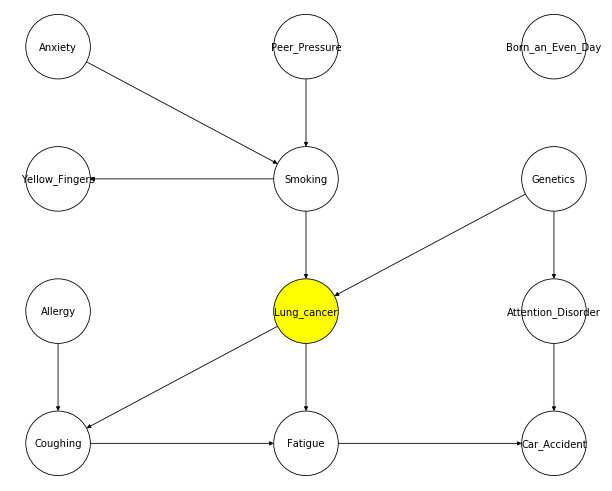

In [7]:
G = nx.DiGraph(directed=True)
G.add_nodes_from(feature_names)
G.add_edges_from(edges_list)

position = {'Anxiety': (-1, 1), 'Peer_Pressure': (0, 1), 'Born_an_Even_Day': (1, 1), 
       'Yellow_Fingers': (-1, 0), 'Smoking': (0, 0),'Genetics': (1, 0), 
       'Allergy': (-1, -1), 'Lung_cancer': (0, -1),'Attention_Disorder': (1, -1),
      'Coughing': (-1, -2), 'Fatigue': (0, -2), 'Car_Accident': (1, -2)}

color_map = ['yellow' if node == target_node else 'w' for node in G]

fig = plt.figure(1, figsize=(10, 8), dpi=60)
nx.draw(G, pos = position, with_labels=True, node_size=6000, node_color=color_map, edgecolors ='black')
nx.write_gml(G, "causal_graph.gml")

In [8]:
print("Current number of nodes in the graph is ", G.number_of_nodes())
print("Current number of edges in the graph is ", G.number_of_edges())

Current number of nodes in the graph is  12
Current number of edges in the graph is  12


In [9]:
# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

In [10]:
print(gml_to_string("causal_graph.gml"))

graph [  directed 1  node [    id 0    label "Smoking"  ]  node [    id 1    label "Yellow_Fingers"  ]  node [    id 2    label "Anxiety"  ]  node [    id 3    label "Peer_Pressure"  ]  node [    id 4    label "Genetics"  ]  node [    id 5    label "Attention_Disorder"  ]  node [    id 6    label "Born_an_Even_Day"  ]  node [    id 7    label "Car_Accident"  ]  node [    id 8    label "Fatigue"  ]  node [    id 9    label "Allergy"  ]  node [    id 10    label "Coughing"  ]  node [    id 11    label "Lung_cancer"  ]  edge [    source 0    target 1  ]  edge [    source 0    target 11  ]  edge [    source 2    target 0  ]  edge [    source 3    target 0  ]  edge [    source 4    target 11  ]  edge [    source 4    target 5  ]  edge [    source 5    target 7  ]  edge [    source 8    target 7  ]  edge [    source 9    target 10  ]  edge [    source 10    target 8  ]  edge [    source 11    target 10  ]  edge [    source 11    target 8  ]]


### Create Model (treatment = Smoking)

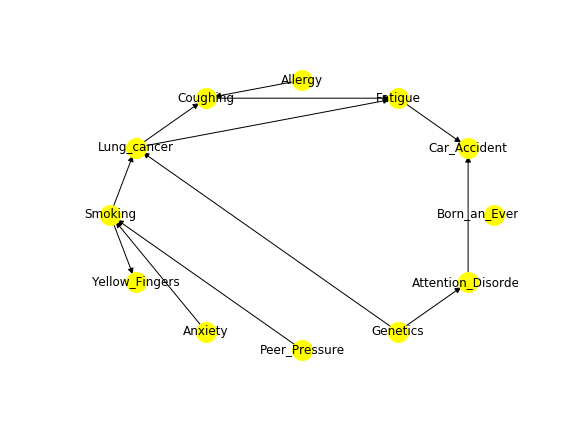

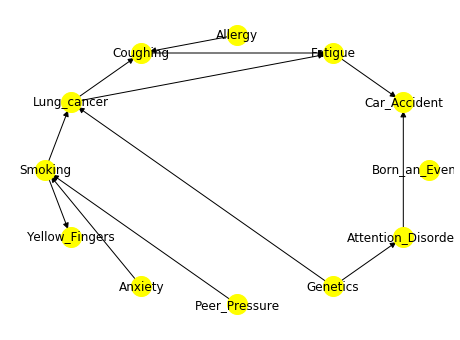

In [56]:
gml_graph = gml_to_string('causal_graph.gml')
# With GML string
model=CausalModel(
        data = df,
        treatment=[
                'Anxiety'
                # , 
                # 'Genetics'
                ]
                ,
        outcome='Car_Accident',
        graph=gml_graph
        )
model.view_model()

# display(Image(filename="causal_model.png", width = 800, height = 2000))

## STEP 2: Identify causal effect using properties of the formal causal graph



In [57]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                
──────────(Expectation(Car_Accident))
d[Anxiety]                           
Estimand assumption 1, Unconfoundedness: If U→{Anxiety} and U→Car_Accident then P(Car_Accident|Anxiety,,U) = P(Car_Accident|Anxiety,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
Expectation(Derivative(Car_Accident, [Smoking])*Derivative([Smoking], [Anxiety
]))
Estimand assumption 1, Full-mediation: Smoking intercepts (blocks) all directed paths from Anxiety to C,a,r,_,A,c,c,i,d,e,n,t.
Estimand assumption 2, First-stage-unconfoundedness: If U→{Anxiety} and U→{Smoking} then P(Smoking|Anxiety,U) = P(Smoking|Anxiety)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Smoking} and U→Car_Accident then P(Car_Accident|Smoking, Anxiety, U) = P(Car_Accident|Smoking, Anxiety)



## STEP 3: Estimate the causal effect

In [59]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print("Causal Estimate is " + str(estimate.value))

Exception: Propensity score methods are applicable only for binary treatments

In [38]:
estimate.get_confidence_intervals()

C:\Users\timod\Anaconda3\lib\site-packages\dowhy\causal_estimator.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_quantiles, duplicates="drop")


## STEP 4: Refuting the estimate

Replacing treatment with a random (placebo) variable.

In [18]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:0.5101072997779666
New effect:-0.0010962923261241331
p value:0.47



Removing a random subset of the data.

In [19]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:0.5101072997779666
New effect:0.5094844019166123
p value:0.43000000000000005



## Independence Tests - TO DO

In [20]:
import conditional_independence.ci_tests.nonparametric.hsic as cond_hsic

res = cond_hsic.hsic_test(df.to_numpy(), 0, 1, [2])
print(res)

{'statistic': 0.018827464891391102, 'p_value': 0.0, 'reject': True, 'mean_approx': 2.19660144463677e-05, 'var_approx': 2.8231318370421153e-09}


## TUTORIAL 3

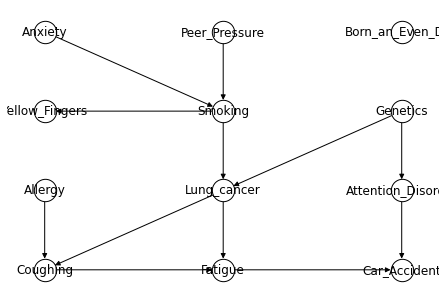

In [24]:
nx.draw(G, pos= position, with_labels=True, node_size=500, node_color='w', edgecolors ='black')
nx.write_gml(G, "backdoor_criterion_graph.gml")

In [74]:
nx.descendants(G,'Lung_cancer') | {'Lung_cancer'}

{'Car_Accident', 'Coughing', 'Fatigue', 'Lung_cancer'}

In [75]:
# importing the backdoor class from DoWhy
from dowhy.causal_identifiers import backdoor

# creating a copy of our graph G that is undirected
H = G.to_undirected()

In [76]:
# the all_simple_paths function finds all possible undirected paths between 'X' and 'Y' in graph H
# the [x for x ...] is simply to get the values from the generator
all_possible_paths = [x for x in nx.all_simple_paths(H, 'Lung_cancer', 'Car_Accident')]



In [77]:
all_possible_paths

[['Lung_cancer', 'Genetics', 'Attention_Disorder', 'Car_Accident'],
 ['Lung_cancer', 'Coughing', 'Fatigue', 'Car_Accident'],
 ['Lung_cancer', 'Fatigue', 'Car_Accident']]

In [78]:
# we can create a Backdoor object with G, 'X', and 'Y'
# note that we are back to using the directed graph, G, as we only needed the undirected to find the paths
graph_nodes = backdoor.Backdoor(G, 'Lung_cancer', 'Car_Accident')


In [79]:
# we apply the is_backdoor function to each path to check if a path is a backdoor path
backdoor_paths_idx = [graph_nodes.is_backdoor(x) for x in all_possible_paths]

# finally, we filter out all non-backdoor paths from the list of all paths
backdoor_paths = [i for indx,i in enumerate(all_possible_paths) if backdoor_paths_idx[indx]]


In [80]:
# we can then view these paths
backdoor_paths

[['Lung_cancer', 'Genetics', 'Attention_Disorder', 'Car_Accident']]

In [81]:
# we create a pandas dataframe to track the path and its colliders and non-colliders
adjustment_variables = pd.DataFrame(columns=['path', 'colliders_desc', 'non_colliders'])

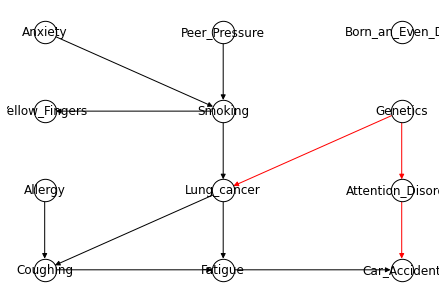

In [105]:
colors = ['black', 'black', 'black', 'black', 'r', 'r', 'r', 'black', 'black', 'black', 'black','black']
nx.draw(G, pos= position, with_labels=True, node_size=500, node_color='w', edgecolors = 'black', edge_color =colors)

In [106]:
# this is the path we are testing
path = ['Lung_cancer', 'Genetics', 'Attention_Disorder', 'Car_accident']

# we create empty (for now) lists for our colliders and non-colliders
# we also create a variable for the length of the path
colliders_desc = np.array([])
non_colliders = []
path_len = len(path)

# we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
    # if there is an arrow pointing into node1 from both sides on the path, it is a collider
    if G.has_edge(node0, node1) and G.has_edge(node2, node1):
        colliders_desc = np.append(colliders_desc, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
# we flatten the list of list
colliders_desc = colliders_desc.flatten()
        
# any node on the path (excluding the source and target) that is not a collider is a non-collider
non_colliders = [x for x in path[1:-1] if x not in colliders_desc]

# finally, we add the information to our dataframe, with the path, colliders, and non-colliders
adjustment_variables = adjustment_variables.append({'path':path, 'colliders_desc': colliders_desc, 
                                                    'non_colliders': non_colliders}, ignore_index=True)

adjustment_variables


,path,colliders_desc,non_colliders
0,"[Lung_cancer, Genetics, Attention_Disorder, Ca...",[],"[Genetics, Attention_Disorder]"


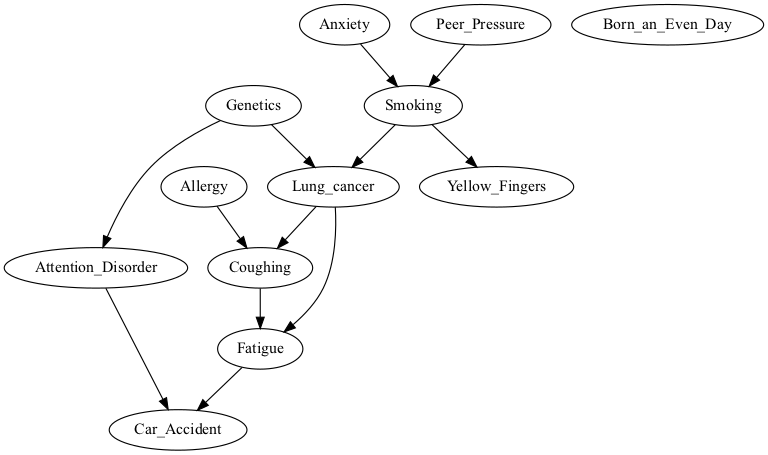

In [110]:
# creating arbitrary data
df = pd.DataFrame({'Anxiety':[1],'Yellow_Fingers':[1],'Smoking':[1],'Lung_cancer':[1],'Allergy':[1],'Coughing':[1],
                  'Genetics': [1], 'Fatigue': [1], 'Attention_Disorder': [1], 'Car_Accident': [1]})


# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

from IPython.display import Image, display

gml_graph = gml_to_string('backdoor_criterion_graph.gml')
# With GML string
model=CausalModel(
        data = df,
        treatment='Lung_cancer',
        outcome='Car_Accident',
        graph=gml_graph
        )
model.view_model()

display(Image(filename="causal_model.png", width = 3300, height = 400))

In [111]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                     
──────────────(Expectation(Car_Accident|Attention_Disorder))
d[Lung_cancer]                                              
Estimand assumption 1, Unconfoundedness: If U→{Lung_cancer} and U→Car_Accident then P(Car_Accident|Lung_cancer,Attention_Disorder,U) = P(Car_Accident|Lung_cancer,Attention_Disorder)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(Car_Accident, [Smoking])*Derivative([Lung_cancer], [Smo
king])**(-1))
Estimand assumption 1, As-if-random: If U→→Car_Accident then ¬(U →→{Smoking})
Estimand assumption 2, Exclusion: If we remove {Smoking}→{Lung_cancer}, then ¬({Smoking}→Car_Accident)

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
Expectation(Derivative(Car_Accident, [Fatigue])*Derivative([Fatigue], [Lung_ca
ncer]))
Estimand assumption 1, Full-mediation: Fatigue intercepts

In [112]:
identifier = model.identifier
identifier.identify_backdoor(identifier.treatment_name, identifier.outcome_name)

[{'backdoor_set': ('Attention_Disorder',
   'Genetics',
   'Allergy',
   'Yellow_Fingers',
   'Anxiety',
   'Smoking')},
 {'backdoor_set': ('Attention_Disorder',)},
 {'backdoor_set': ('Genetics',)}]

## TUTORIAL 4

In [ ]:
# frontdoor, IV